# Building makemore: Multi-layer perceptron

https://www.youtube.com/watch?v=TCH_1BHY58I

Last time: two models, the first using counts and normalizing them to generate the next character in a sequence. Problem: using more characters grows exponentially. With the stop character, $27^n$.

# Benigo et al. approach

Better approach: multi-layer perceptron to predict future characters. Scales much better. See: https://www.jmlr.org/papers/volume3/bengio03a/bengio03a.pdf

Goes from 17,000 feature vectors to a 30-dimension space (dimensionality reduction). Approach otherwise is as seen in the previous lecture.

Intuitively, "walking" and "running" should be close to one another in the model space, so if the model's never seen "The dog was running in the ___" but it's seen "The cat was walking in the bedroom" it'll consider bedroom a likely word to fill in the blank. (Sounds like word embeddings.)

Network architecture: embedded input layers, hidden layer (30 parameters), output layer (17,000 parameters). Use softmax to take most probable words when generating a sequence.

# Network architecture

In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [2]:
# Import data
words = open('makemore/names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [3]:
len(words)

32033

In [4]:
# Build vocabulary - same approach as last lecture, identical code
# Put special . as 0 element, and shift the alphabet over by 1
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


## Lookup table

In [5]:
# Build dataset - new approach using block_size to use the previous n characters to predict the next
block_size = 3 # context length: how many characters do we take to predict the next one?
X, Y = [], [] # input, and labels, to neural network

for w in words[:5]: # Test on just first few names
    print(w)
    context = [0] * block_size
    for ch in w + '.':
        ix = stoi[ch]
        X.append(context)
        Y.append(ix)
        print(''.join(itos[i] for i in context), '-->', itos[ix])
        context = context[1:] + [ix] # crop and append

# Save results
X = torch.tensor(X)
Y = torch.tensor(Y)

emma
... --> e
..e --> m
.em --> m
emm --> a
mma --> .
olivia
... --> o
..o --> l
.ol --> i
oli --> v
liv --> i
ivi --> a
via --> .
ava
... --> a
..a --> v
.av --> a
ava --> .
isabella
... --> i
..i --> s
.is --> a
isa --> b
sab --> e
abe --> l
bel --> l
ell --> a
lla --> .
sophia
... --> s
..s --> o
.so --> p
sop --> h
oph --> i
phi --> a
hia --> .


5 examples can be generated: the 4 letters and the stop character. Note that initially there is no previous character, then e, em, emm, mma. The block size is a rolling window.

In [6]:
X.shape, X.dtype, Y.shape, Y.dtype

(torch.Size([32, 3]), torch.int64, torch.Size([32]), torch.int64)

The paper had 17,000 words, while we have 27 characters (a-z and .) so we need a dimension <27, 2> lookup table.

Conceptually, we use a one-hot encoded vector (indicator) to pull out the desired row from the lookup matrix as before. But this time it'll be indexed because this is faster to look up values.

In [7]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27, 2), generator = g)
F.one_hot(torch.tensor(5), num_classes = 27).float() @ C

tensor([-0.4713,  0.7868])

Embedding a single integer: easy, just return e.g. `C[5]`. Works the same way for tensors.

In [8]:
C[torch.tensor([5, 6, 7, 7, 7])]

tensor([[-0.4713,  0.7868],
        [-0.3284, -0.4330],
        [ 1.3729,  2.9334],
        [ 1.3729,  2.9334],
        [ 1.3729,  2.9334]])

In [9]:
C[X].shape

torch.Size([32, 3, 2])

In [10]:
C[X][4,2]

tensor([-0.0274, -1.1008])

In [11]:
emb = C[X]
emb.shape

torch.Size([32, 3, 2])

## Hidden layer

Weights are initialized randomly as usual; it'll be 3 * 2 = 6 inputs, due to 2-dimensional embeddings * 3 block size. The number of neurons is up to us.

In [12]:
W1 = torch.randn((6, 100), generator = g)
b1 = torch.randn(100, generator = g)

`emb @ W1 + b1` doesn't work due to dimensionality of emb. Need to concatenate the 3, 2 into 6 to do matrix multiplication with `W1`.

In [13]:
# Use torch.cat to concatenate the embeddings for each imput.
emb[:, 0, :].shape, emb[:, 1, :].shape, emb[:, 2, :].shape

(torch.Size([32, 2]), torch.Size([32, 2]), torch.Size([32, 2]))

In [14]:
# Concatenate on the 1st indexed dimension
torch.cat([emb[:, 0, :], emb[:, 1, :], emb[:, 2, :]], 1).shape

torch.Size([32, 6])

This has the correct dimensions; just needs to be updated to be generalizable based on the block size. Use `torch.unbind` to unwrap the tensor along a given dimension.

In [15]:
torch.cat(torch.unbind(emb, 1), 1).shape

torch.Size([32, 6])

This can be done even more efficiently by recasting the dimensions of a tensor directly by using `view`.

In [16]:
a = torch.arange(18)
a

tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17])

In [17]:
a.view(9, 2)

tensor([[ 0,  1],
        [ 2,  3],
        [ 4,  5],
        [ 6,  7],
        [ 8,  9],
        [10, 11],
        [12, 13],
        [14, 15],
        [16, 17]])

In [18]:
a.view(3, 3, 2)

tensor([[[ 0,  1],
         [ 2,  3],
         [ 4,  5]],

        [[ 6,  7],
         [ 8,  9],
         [10, 11]],

        [[12, 13],
         [14, 15],
         [16, 17]]])

As long as the arguments multiply to 18 in this case, the sequence can be represented with the given dimensions without any additional memory being used. Very efficient!

In [19]:
# Same as concatenation before
emb.view(32, 6)

tensor([[ 1.5674, -0.2373,  1.5674, -0.2373,  1.5674, -0.2373],
        [ 1.5674, -0.2373,  1.5674, -0.2373, -0.4713,  0.7868],
        [ 1.5674, -0.2373, -0.4713,  0.7868,  2.4448, -0.6701],
        [-0.4713,  0.7868,  2.4448, -0.6701,  2.4448, -0.6701],
        [ 2.4448, -0.6701,  2.4448, -0.6701, -0.0274, -1.1008],
        [ 1.5674, -0.2373,  1.5674, -0.2373,  1.5674, -0.2373],
        [ 1.5674, -0.2373,  1.5674, -0.2373, -1.0725,  0.7276],
        [ 1.5674, -0.2373, -1.0725,  0.7276, -0.0707,  2.4968],
        [-1.0725,  0.7276, -0.0707,  2.4968,  0.6772, -0.8404],
        [-0.0707,  2.4968,  0.6772, -0.8404, -0.1158, -1.2078],
        [ 0.6772, -0.8404, -0.1158, -1.2078,  0.6772, -0.8404],
        [-0.1158, -1.2078,  0.6772, -0.8404, -0.0274, -1.1008],
        [ 1.5674, -0.2373,  1.5674, -0.2373,  1.5674, -0.2373],
        [ 1.5674, -0.2373,  1.5674, -0.2373, -0.0274, -1.1008],
        [ 1.5674, -0.2373, -0.0274, -1.1008, -0.1158, -1.2078],
        [-0.0274, -1.1008, -0.1158, -1.2

In [20]:
emb.view(32, 6) @ W1 + b1

tensor([[-1.6952e+00,  8.5502e+00,  1.6284e+00,  ...,  2.2642e+00,
         -1.9505e-01,  1.8469e+00],
        [ 2.8741e-01,  4.3343e+00,  1.0142e+00,  ...,  2.8221e+00,
          3.9128e+00,  3.4733e+00],
        [-3.1026e+00,  9.9601e+00, -1.3306e+00,  ..., -5.7069e-01,
         -5.9107e+00, -6.9120e-03],
        ...,
        [-4.3248e+00,  7.4938e+00, -1.6386e+00,  ..., -5.1557e+00,
         -3.3276e+00, -3.2464e+00],
        [-1.4951e+00,  5.6195e+00,  2.5079e+00,  ..., -1.0607e+00,
         -5.2543e-01,  3.4893e+00],
        [-1.4982e+00,  8.5941e+00,  1.8897e+00,  ...,  2.4983e+00,
          6.9596e+00,  2.6822e+00]])

In [21]:
# Even better, have pytorch infer the dimensions
emb.view(-1, 6) @ W1 + b1

tensor([[-1.6952e+00,  8.5502e+00,  1.6284e+00,  ...,  2.2642e+00,
         -1.9505e-01,  1.8469e+00],
        [ 2.8741e-01,  4.3343e+00,  1.0142e+00,  ...,  2.8221e+00,
          3.9128e+00,  3.4733e+00],
        [-3.1026e+00,  9.9601e+00, -1.3306e+00,  ..., -5.7069e-01,
         -5.9107e+00, -6.9120e-03],
        ...,
        [-4.3248e+00,  7.4938e+00, -1.6386e+00,  ..., -5.1557e+00,
         -3.3276e+00, -3.2464e+00],
        [-1.4951e+00,  5.6195e+00,  2.5079e+00,  ..., -1.0607e+00,
         -5.2543e-01,  3.4893e+00],
        [-1.4982e+00,  8.5941e+00,  1.8897e+00,  ...,  2.4983e+00,
          6.9596e+00,  2.6822e+00]])

In [22]:
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
h.shape

torch.Size([32, 100])

Note the `+ b1` which is a constant bias term; due to Torch's internals even though b1 is a constant vector it will be copied down and added to all rows correctly; always worth checking this.

## Output layer

Input is 100 neurons, output is 27 possible characters.

In [23]:
W2 = torch.randn((100, 27), generator = g)
b2 = torch.randn(27, generator = g)

In [24]:
logits = h @ W2 + b2
logits.shape

torch.Size([32, 27])

In [25]:
counts = logits.exp()
prob = counts / counts.sum(1, keepdims = True) # Sum along first dimension
prob.shape

torch.Size([32, 27])

In [26]:
prob[0].sum()

tensor(1.)

Rows sum to 1.

Still need to grab probabilities and index prob, and compare to Y.

In [27]:
prob[torch.arange(32), Y]

tensor([1.5213e-14, 1.2830e-12, 1.9647e-08, 3.1758e-10, 5.6763e-12, 1.0823e-10,
        1.8821e-14, 1.1087e-08, 1.6134e-09, 2.1917e-03, 5.3863e-08, 3.1970e-04,
        2.0283e-10, 3.5710e-11, 6.2336e-07, 5.1704e-07, 1.4206e-01, 9.5657e-09,
        2.0671e-09, 2.5181e-02, 7.6846e-05, 2.8706e-12, 1.6961e-09, 5.6464e-15,
        4.4656e-03, 2.6851e-09, 3.5865e-05, 2.3389e-04, 1.6890e-09, 9.5614e-01,
        9.7404e-10, 2.1230e-12])

Negative log likelihood is defined as before, and will be minimized.

In [28]:
loss = -prob[torch.arange(32), Y].log().mean()
loss

tensor(17.7697)

## Cleaned up code

In [29]:
X.shape, Y.shape

(torch.Size([32, 3]), torch.Size([32]))

In [30]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27, 2), generator = g)
W1 = torch.randn((6, 100), generator = g)
b1 = torch.randn(100, generator = g)
W2 = torch.randn((100, 27), generator = g)
b2 = torch.randn(27, generator = g)
parameters = [C, W1, b1, W2, b2]

In [31]:
sum(p.nelement() for p in parameters) # Total parameters

3481

In [32]:
# Should be the same as when we multiply out the tensor sizes
27 * 2 + 6 * 100 + 100 + 100 * 27 + 27

3481

In [33]:
# Loss function with current parameters
emb = C[X] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
counts = logits.exp()
prob = counts / counts.sum(1, keepdims = True)
loss = -prob[torch.arange(32), Y].log().mean()
loss

tensor(17.7697)

Can be further optimized with the `corss_entropy` function which takes the place of the `counts =`, `prob =`, `loss =`

In [34]:
# Loss function with current parameters
emb = C[X] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
#counts = logits.exp()
#prob = counts / counts.sum(1, keepdims = True)
#loss = -prob[torch.arange(32), Y].log().mean()
loss = F.cross_entropy(logits, Y)
loss # Should be same as above

tensor(17.7697)

Always best to use the built-in operations like `cross_entropy` because intermediate steps aren't saved. It's also a better, more efficient implementation for the backward step. Can have a simpler expression when calculating the backpropagation gradients and updates.

Additionally, `cross_entropy` can avoid various numerical issues. Consider what happens with extreme values when you roll your own implementation...

In [35]:
logits = torch.tensor([-100, -3, 0, 5])
counts = logits.exp()
counts / counts.sum()

tensor([0.0000e+00, 3.3311e-04, 6.6906e-03, 9.9298e-01])

This works ok with lower values, but leads to numerical errors with large numbers...

In [36]:
logits = torch.tensor([-100, -3, 0, 100]) # But large numbers lead to numerical errors
counts = logits.exp() # ...due to exp() which blows up with large positive numbers
counts / counts.sum()

tensor([0., 0., 0., nan])

Internally, Pytorch subtracts the maximum from the entire vector to ensure nothing is > 0.

# Training

Need a forward and a backward pass, same as always.

In [37]:
# Needed to make the loop run
for p in parameters:
    p.requires_grad = True

In [38]:
for _ in range(10):

    # Forward pass
    emb = C[X] # (32, 3, 2)
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # (32, 100)
    logits = h @ W2 + b2 # (32, 27)
    loss = F.cross_entropy(logits, Y)
    print(loss.item())
    
    # Backward pass
    for p in parameters:
        p.grad = None

    loss.backward()

    # Update
    for p in parameters:
        p.data += -0.1 * p.grad

17.769710540771484
13.656400680541992
11.298768997192383
9.452457427978516
7.984262943267822
6.891321182250977
6.100014686584473
5.452036380767822
4.898152828216553
4.414663791656494


This decreases very rapidly. If we go to ~1000 we'll get very good predictions on our 32 examples of the first words; overfitting the training data.

In [39]:
for _ in range(1000):

    # Forward pass
    emb = C[X] # (32, 3, 2)
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # (32, 100)
    logits = h @ W2 + b2 # (32, 27)
    loss = F.cross_entropy(logits, Y)
    print(loss.item())
    
    # Backward pass
    for p in parameters:
        p.grad = None

    loss.backward()

    # Update
    for p in parameters:
        p.data += -0.1 * p.grad

3.985849142074585
3.6028308868408203
3.2621419429779053
2.961380958557129
2.6982972621917725
2.469712972640991
2.271660327911377
2.101283550262451
1.9571770429611206
1.837485909461975
1.7380964756011963
1.6535112857818604
1.5790895223617554
1.5117661952972412
1.4496045112609863
1.3913116455078125
1.335992455482483
1.2830525636672974
1.232190728187561
1.183381199836731
1.1367985010147095
1.0926637649536133
1.0510920286178589
1.0120267868041992
0.9752705693244934
0.9405564069747925
0.9076123833656311
0.876192033290863
0.8460887670516968
0.8171355724334717
0.7891988158226013
0.7621744275093079
0.7359810471534729
0.7105576992034912
0.685860812664032
0.6618651151657104
0.6385656595230103
0.6159816384315491
0.5941658020019531
0.5732104778289795
0.5532562136650085
0.5344880819320679
0.5171165466308594
0.5013311505317688
0.48724257946014404
0.47484031319618225
0.4639976918697357
0.4545140564441681
0.44617074728012085
0.4387663006782532
0.43213313817977905
0.4261387884616852
0.42067983746528625

Can never get down to 0 with a perfect fit because e.g. the first index ... is equally likely to return e, a, o, ..., but the other characters have a unique input leading to a unique output.

## Full dataset



In [40]:
# Build dataset - new approach using block_size to use the previous n characters to predict the next
block_size = 3 # context length: how many characters do we take to predict the next one?
X, Y = [], [] # input, and labels, to neural network

for w in words: # Test on just first few names
    #print(w)
    context = [0] * block_size
    for ch in w + '.':
        ix = stoi[ch]
        X.append(context)
        Y.append(ix)
        #print(''.join(itos[i] for i in context), '-->', itos[ix])
        context = context[1:] + [ix] # crop and append

# Save results
X = torch.tensor(X)
Y = torch.tensor(Y)

In [41]:
X.shape, X.dtype, Y.shape, Y.dtype

(torch.Size([228146, 3]), torch.int64, torch.Size([228146]), torch.int64)

Try rerunning the model with the same initialization, parameter dimensions but much more data.

In [42]:
def make_parameters(seed = 2147483647):
    g = torch.Generator().manual_seed(seed)
    C = torch.randn((27, 2), generator = g)
    W1 = torch.randn((6, 100), generator = g)
    b1 = torch.randn(100, generator = g)
    W2 = torch.randn((100, 27), generator = g)
    b2 = torch.randn(27, generator = g)
    parameters = [C, W1, b1, W2, b2]
    # Needed to make the loop run
    for p in parameters:
        p.requires_grad = True
    return g, C, W1, b1, W2, b2, parameters

In [43]:
g, C, W1, b1, W2, b2, parameters = make_parameters()

In [44]:
for _ in range(20):

    # Forward pass
    emb = C[X] # (32, 3, 2)
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # (32, 100)
    logits = h @ W2 + b2 # (32, 27)
    loss = F.cross_entropy(logits, Y)
    print(loss.item())
    
    # Backward pass
    for p in parameters:
        p.grad = None

    loss.backward()

    # Update
    for p in parameters:
        p.data += -0.1 * p.grad

19.505229949951172
17.084495544433594
15.776534080505371


14.833340644836426
14.002596855163574
13.253252029418945
12.579911231994629
11.9830961227417
11.470492362976074
11.051856994628906
10.709589004516602
10.407635688781738
10.127811431884766
9.86436939239502
9.614506721496582
9.376442909240723
9.148948669433594
8.93111515045166
8.722233772277832
8.521753311157227


This is noticeably slower than before; 4.2 seconds to run because it's inefficiently going through all 200k+ training examples.

For efficiency: randomly sample the data in batches and update the parameters only on those batches. Should lead to about as good results.

In [45]:
torch.randint(0, 5, (32, ))

tensor([4, 0, 2, 3, 2, 3, 4, 0, 3, 2, 4, 2, 1, 4, 0, 0, 4, 3, 2, 0, 1, 4, 3, 1,
        0, 4, 1, 2, 0, 3, 0, 2])

In [46]:
# Generalized version
torch.randint(0, X.shape[0], (32, ))

tensor([102433,   9814,  91652,  51207, 129639, 123320,  72096,  51467,  79361,
         93954, 176150, 152800, 102726, 109179,  99546, 208112, 123029, 108657,
          3087, 121127, 208060,  64160,  84980, 109857, 207379,  61445, 226424,
         86717, 168980, 225231, 128624,  73666])

In [47]:
for _ in range(1000):

    ix = torch.randint(0, X.shape[0], (32, )) # For randomly selecting 32 rows of data

    # Forward pass
    emb = C[X[ix]] # (32, 3, 2); only grab ix rows
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # (32, 100)
    logits = h @ W2 + b2 # (32, 27)
    loss = F.cross_entropy(logits, Y[ix]) # Only grab ix rows
    print(loss.item())
    
    # Backward pass
    for p in parameters:
        p.grad = None

    loss.backward()

    # Update
    for p in parameters:
        p.data += -0.1 * p.grad

6.926772594451904
10.532811164855957
9.693974494934082
7.263444423675537
7.875650405883789
8.556546211242676
7.139679908752441
8.364435195922852
6.461527347564697
6.858159065246582
7.073001861572266
8.071428298950195
6.570007801055908
6.08051872253418
7.6064043045043945
6.5457611083984375
6.351294040679932
5.201539993286133
6.356577396392822
4.916750431060791
6.040419101715088
5.464047431945801
4.966925621032715
6.679656028747559
5.945621490478516
6.347047805786133
6.545732498168945
5.953789234161377
5.367094993591309
6.516734600067139
6.078299522399902
5.878421783447266
4.802438259124756
4.641851425170898
5.384029865264893
4.875652313232422
4.538542747497559
3.1303696632385254
3.6793572902679443
4.666067600250244
4.753857135772705
4.604435920715332
5.7665252685546875
4.33361291885376
6.130228042602539
5.403964996337891
4.546337127685547
3.6594834327697754
4.319334506988525
4.124264717102051
4.182192802429199
4.577882289886475
4.0338263511657715
5.238301753997803
4.648142337799072
3.04

This is much faster, but since we're sampling the gradient is not as reliable; note that the function moves down overall but individual steps can have higher loss than before. Good enough to be useful.

This is standard practice: better to evaluate an approximation of the gradient with many steps, instead of a few steps with the exact gradient.

To double check, look at the exact loss function, not just on the mini batch of 32.

In [48]:
def printExactLoss():
    emb = C[X] # (32, 3, 2)
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # (32, 100)
    logits = h @ W2 + b2 # (32, 27)
    loss = F.cross_entropy(logits, Y)
    print(loss.item())

In [49]:
printExactLoss()

2.7534122467041016


## Choosing a learning rate

Additional optimization: what is the right learning speed hyperparameter? -0.1 was arbitrary.

In [50]:
# Reset parameters
g, C, W1, b1, W2, b2, parameters = make_parameters()
learningrate = .0001 # Too low

for _ in range(100):

    ix = torch.randint(0, X.shape[0], (32, )) # For randomly selecting 32 rows of data

    # Forward pass
    emb = C[X[ix]] # (32, 3, 2); only grab ix rows
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # (32, 100)
    logits = h @ W2 + b2 # (32, 27)
    loss = F.cross_entropy(logits, Y[ix]) # Only grab ix rows
    print(loss.item())
    
    # Backward pass
    for p in parameters:
        p.grad = None

    loss.backward()

    # Update
    for p in parameters:
        p.data += -learningrate * p.grad

19.689495086669922
21.639951705932617
20.025785446166992
18.13319969177246
16.47211456298828
19.666629791259766
17.735702514648438
18.66973114013672
18.780397415161133
19.551769256591797
18.92703628540039
20.391281127929688
21.357391357421875
22.67078399658203
20.105663299560547
18.19432830810547
23.07483673095703
18.152408599853516
19.764619827270508
19.147438049316406
20.010087966918945
17.14966583251953
19.315690994262695
22.354372024536133
18.4157772064209
21.69523048400879
18.506877899169922
19.736034393310547
18.12925148010254
17.299036026000977
18.12759780883789
18.38648796081543
18.137983322143555
19.12024688720703
19.335350036621094
21.507802963256836
18.716259002685547
21.506765365600586
23.75618553161621
19.45638084411621
17.411945343017578
20.49051284790039
18.941701889038086
17.577369689941406
19.177032470703125
19.697166442871094
17.7371768951416
19.567644119262695
18.331640243530273
19.90231704711914
19.66337776184082
19.804950714111328
18.488784790039062
17.403549194335

Learning rate barely decreasing at all; this is clearly not sufficient.

In [51]:
# Reset parameters
g, C, W1, b1, W2, b2, parameters = make_parameters()
learningrate = .001 # Pretty low

for _ in range(100):

    ix = torch.randint(0, X.shape[0], (32, )) # For randomly selecting 32 rows of data

    # Forward pass
    emb = C[X[ix]] # (32, 3, 2); only grab ix rows
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # (32, 100)
    logits = h @ W2 + b2 # (32, 27)
    loss = F.cross_entropy(logits, Y[ix]) # Only grab ix rows
    print(loss.item())
    
    # Backward pass
    for p in parameters:
        p.grad = None

    loss.backward()

    # Update
    for p in parameters:
        p.data += -learningrate * p.grad

19.258596420288086
20.328990936279297
19.864408493041992
19.601987838745117
17.57638168334961
16.71140480041504
18.59832000732422
18.077180862426758
19.59163475036621
22.58440589904785
17.370468139648438
19.761919021606445
18.986431121826172
19.15898323059082
20.18491554260254
18.5126953125
19.532976150512695
18.921619415283203
18.146549224853516
17.363239288330078
17.963258743286133
19.898181915283203
18.980623245239258
14.753584861755371
20.10309600830078
19.957252502441406
16.725582122802734
16.98567771911621
20.99211311340332
16.571216583251953
16.01493263244629
18.944032669067383
17.959253311157227
19.065093994140625
16.307710647583008
21.09596061706543
17.986534118652344
20.893285751342773
19.016658782958984
16.440876007080078
16.197364807128906
17.000925064086914
19.544063568115234
15.856797218322754
16.570117950439453
18.905473709106445
19.37773895263672
18.498981475830078
17.721193313598633
19.121732711791992
19.828052520751953
16.16739273071289
18.79453468322754
19.4271030426

Clearly decreasing over time; this would be a suitable range.

If the loss function is too big, the function will "explode" - no consistent behavior, overshooting each step.

In [52]:
# Reset parameters
g, C, W1, b1, W2, b2, parameters = make_parameters()
learningrate = 10 # Way too high

for _ in range(100):

    ix = torch.randint(0, X.shape[0], (32, )) # For randomly selecting 32 rows of data

    # Forward pass
    emb = C[X[ix]] # (32, 3, 2); only grab ix rows
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # (32, 100)
    logits = h @ W2 + b2 # (32, 27)
    loss = F.cross_entropy(logits, Y[ix]) # Only grab ix rows
    print(loss.item())
    
    # Backward pass
    for p in parameters:
        p.grad = None

    loss.backward()

    # Update
    for p in parameters:
        p.data += -learningrate * p.grad

18.19137191772461
38.56006622314453
79.71997833251953
73.02641296386719
65.33867645263672
62.07798385620117
76.64058685302734
47.060020446777344
58.74861526489258
69.1828384399414
97.53173065185547
57.3383674621582
51.46820068359375
75.11175537109375
93.74197387695312
71.24820709228516
100.69364166259766
88.56722259521484
81.03475952148438
72.85397338867188
129.0100555419922
120.06587219238281
122.50243377685547
81.39966583251953
74.82206726074219
79.32843780517578
94.40128326416016
94.83612060546875
88.52925109863281
94.87078094482422
68.30113983154297
89.38113403320312
65.24756622314453
80.03022003173828
84.6998519897461
64.5587158203125
89.71086120605469
77.8179931640625
73.19364166259766
81.76777648925781
70.92098236083984
69.97529602050781
55.27585983276367
65.10738372802734
77.96126556396484
93.21357727050781
74.26749420166016
67.88654327392578
81.990966796875
81.76969909667969
53.68246841430664
84.71563720703125
60.383628845214844
44.364593505859375
84.88764953613281
95.02046203

The right learning rate is probably somewhere between -0.001 and 1 based on the above. Let's try a few of them.

In [53]:
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre
lrs

tensor([0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0011,
        0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011,
        0.0011, 0.0011, 0.0011, 0.0012, 0.0012, 0.0012, 0.0012, 0.0012, 0.0012,
        0.0012, 0.0012, 0.0012, 0.0012, 0.0012, 0.0012, 0.0013, 0.0013, 0.0013,
        0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0014,
        0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014,
        0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015,
        0.0015, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016,
        0.0016, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017,
        0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0019,
        0.0019, 0.0019, 0.0019, 0.0019, 0.0019, 0.0019, 0.0019, 0.0020, 0.0020,
        0.0020, 0.0020, 0.0020, 0.0020, 0.0020, 0.0021, 0.0021, 0.0021, 0.0021,
        0.0021, 0.0021, 0.0021, 0.0022, 

Creating 1000 possible learning rates that can be evaluated empirically (basically a grid search type approach, on this single parameter).

In [54]:
# Reset parameters
g, C, W1, b1, W2, b2, parameters = make_parameters()
learningrate = 10 # Way too high

# Track learning rates and losses
lri = []
lossi = []

# Loop through learning rates

for i in range(1000):

    ix = torch.randint(0, X.shape[0], (32, )) # For randomly selecting 32 rows of data

    # Forward pass
    emb = C[X[ix]] # (32, 3, 2); only grab ix rows
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # (32, 100)
    logits = h @ W2 + b2 # (32, 27)
    loss = F.cross_entropy(logits, Y[ix]) # Only grab ix rows
    print(loss.item())
    
    # Backward pass
    for p in parameters:
        p.grad = None

    loss.backward()

    # Update
    lr = lrs[i]
    for p in parameters:
        p.data += -lr * p.grad

    # Track stats
    lri.append(lr)
    lossi.append(loss.item())

17.132490158081055
19.455129623413086
20.588970184326172
24.09821128845215
21.223533630371094
19.29668426513672
19.168479919433594
20.842010498046875
16.70177459716797
18.323076248168945
20.424617767333984
18.597681045532227
20.67469596862793
17.563135147094727
20.723798751831055
16.76476287841797
15.883875846862793
16.99184799194336
17.91368865966797
19.987173080444336
17.34787940979004
17.463735580444336
19.872007369995117
18.67708396911621
18.186656951904297
21.251771926879883
13.531333923339844
19.398515701293945
17.969327926635742
22.386938095092773
20.27665138244629
13.615514755249023
18.392223358154297
20.45591926574707
21.547542572021484
18.939067840576172
20.572460174560547
21.110401153564453
19.020118713378906
17.107799530029297
16.90305519104004
18.861623764038086
18.272930145263672
19.198801040649414
18.612844467163086
20.476350784301758
18.630727767944336
19.54012680053711
19.61669158935547
18.115493774414062
19.542621612548828
14.696014404296875
19.827133178710938
17.5306

9.167119979858398
10.24587345123291
10.502156257629395
12.514373779296875
9.23038101196289
11.842397689819336
10.035550117492676
11.670866012573242
10.344599723815918
10.818347930908203
9.844173431396484
8.784342765808105
11.543109893798828
9.467310905456543
9.141812324523926
10.33803939819336
9.307416915893555
8.079180717468262
9.205039978027344
11.127792358398438
9.38379955291748
8.650656700134277
11.119937896728516
9.041364669799805
9.647001266479492
9.371312141418457
9.700767517089844
10.818371772766113
9.2669095993042
8.50308609008789
10.899491310119629
8.674166679382324
10.9971923828125
7.954708099365234
7.131963729858398
10.66605281829834
9.22916030883789
10.726546287536621
9.896520614624023
9.675370216369629
11.392810821533203
10.243154525756836
8.755273818969727
9.082051277160645
10.5385160446167
7.8172221183776855
9.871452331542969
8.081914901733398
9.208235740661621
6.8119401931762695
8.677042007446289
8.805434226989746
8.591714859008789
5.741908073425293
8.773880958557129
9

Now we can just plot the learning rates and losses and see if there's a local minimum.

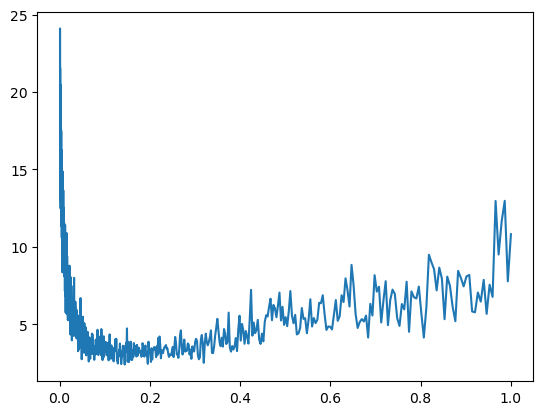

In [55]:
plt.plot(lri, lossi)

At the beginning, we have very nice decreases but at some point it increases again and starts going nuts at the end. Looks like 0.1 is a good learning rate.

Can also look at the exponent $10^x$ of the learning rate, rather than the learning rate itself.

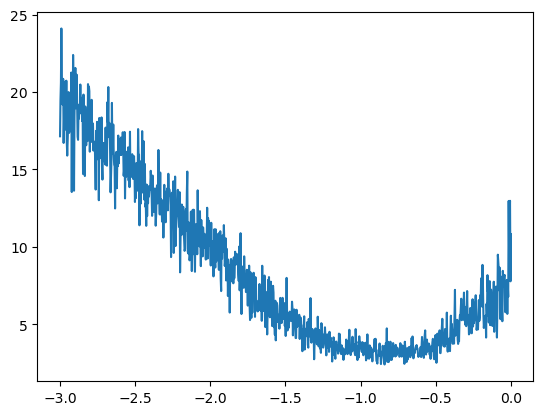

In [56]:
plt.plot(lre, lossi)

The interpretation here is $10^{-1} = 0.1$ is again a good learning rate. We can just use that as the learning rate, and crank up the iterations.

In [63]:
# Reset parameters
g, C, W1, b1, W2, b2, parameters = make_parameters()
lr = 0.1 # Optimized

for _ in range(20000):

    ix = torch.randint(0, X.shape[0], (32, )) # For randomly selecting 32 rows of data

    # Forward pass
    emb = C[X[ix]] # (32, 3, 2); only grab ix rows
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # (32, 100)
    logits = h @ W2 + b2 # (32, 27)
    loss = F.cross_entropy(logits, Y[ix]) # Only grab ix rows
    #print(loss.item())
    
    # Backward pass
    for p in parameters:
        p.grad = None

    loss.backward()

    # Update
    for p in parameters:
        p.data += -lr * p.grad

In [64]:
printExactLoss()

2.502794027328491


In late stages of training, you can further reduce the learning rate to try to fine tune. The best bigram model was around 2.45; so we're already on par.

In [65]:
lr = .01 # Step down learning rate

for _ in range(20000):

    ix = torch.randint(0, X.shape[0], (32, )) # For randomly selecting 32 rows of data

    # Forward pass
    emb = C[X[ix]] # (32, 3, 2); only grab ix rows
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # (32, 100)
    logits = h @ W2 + b2 # (32, 27)
    loss = F.cross_entropy(logits, Y[ix]) # Only grab ix rows
    #print(loss.item())
    
    # Backward pass
    for p in parameters:
        p.grad = None

    loss.backward()

    # Update
    for p in parameters:
        p.data += -lr * p.grad

In [66]:
printExactLoss()

2.3687963485717773


## Training/validation/test splits

So this is a "better" model because it has a lower loss, right? Not exactly - there's a balance between loss function and overfitting. Be cautious of overfit models. As usual, do training/validation/test splits. (The training set can then be cross-validated, etc.) Idea is to withhold parts of the data for training models, fitting hyperparameters, and final validation.